In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain # need this for plots below

%matplotlib inline

# load the dataframe
esg = pd.read_csv('../data/esg_metadata.csv')

In [2]:
# create some arrays of key display and logic fields
expl_a_g = list(map(lambda x: 'expl_'+x, list('abcdefg')))
expl_c_g = list(map(lambda x: 'expl_'+x, list('cdefg')))
explans = ['no_gap']+expl_a_g
core_fields = ['sector','cetsid','input_name']+explans


In [3]:
# 'no_gap' fields should not have any expl variables set
esg.loc[esg['no_gap']==1,expl_a_g] = 0

# expl_a and expl_b should not have any other explanatory variables set
esg.loc[(esg['expl_a']==1) | (esg['expl_b']==1), expl_c_g] = 0

# New column that divides sources into WBG and all other external
esg['domain'] = np.where(esg['source_type']!='WBG','EXTERNAL',esg['source_type'])

In [4]:
# Summarize by type and sector
esg.pivot_table(index='source_type',columns='sector', aggfunc='count',values='cetsid',margins=True).reindex(['WBG', 'UN', 'OTHER', 'All'],axis=0).reindex(['ENV', 'SOC', 'GOV','All'], axis=1)


sector,ENV,SOC,GOV,All
source_type,,,,
WBG,10,12,14,36
UN,9,49,8,66
OTHER,25,5,2,32
All,44,66,24,134


In [5]:
# create a summary table in percentage terms
pt = esg.pivot_table(index='domain',columns='sector', aggfunc='count',values='cetsid')
pt['Total'] = pt.sum(axis=1)
pt

work = pt.copy()
for i in pt.columns:
    work[i] = pt[i] / pt[i].sum()

work.loc['Total'] = pt.sum() / pt.sum()['Total']
work

sector,ENV,GOV,SOC,Total
domain,,,,
EXTERNAL,0.772727,0.416667,0.818182,0.731343
WBG,0.227273,0.583333,0.181818,0.268657
Total,0.328358,0.179104,0.492537,1.000000


In [6]:
# Show explanations, disaggregated by domain
esg.groupby(['domain']).sum()[explans]

,no_gap,expl_a,expl_b,expl_c,expl_d,expl_e,expl_f,expl_g
domain,,,,,,,,
EXTERNAL,8,10,8,58,1,8,19,10
WBG,6,5,3,14,1,0,13,2


In [7]:
# limit to the WBG dataset
esg[esg['wbgv1']==1].groupby(['domain']).sum()[explans]

,no_gap,expl_a,expl_b,expl_c,expl_d,expl_e,expl_f,expl_g
domain,,,,,,,,
EXTERNAL,7,0,4,32,1,6,11,5
WBG,6,0,0,8,1,0,7,1


So to me, the big takeaway here is that the big "gaps" are around methodology and household surveys, but we would be very dependent on external sources to make changes, particularly for the WBG dataset

In [8]:
# Disaggregate by sector as well
esg.groupby(['domain', 'sector']).sum()[explans]

no_gap  expl_a  expl_b  expl_c  expl_d  expl_e  expl_f  \
domain   sector                                                           
EXTERNAL ENV          8       1       8      17       0       8       0   
         GOV          0       3       0       6       0       0       1   
         SOC          0       6       0      35       1       0      18   
WBG      ENV          0       2       3       5       0       0       0   
         GOV          6       0       0       1       0       0       7   
         SOC          0       3       0       8       1       0       6   

                 expl_g  
domain   sector          
EXTERNAL ENV          3  
         GOV          3  
         SOC          4  
WBG      ENV          2  
         GOV          0  
         SOC          0

In [9]:
# just the WBG dataset
esg[esg['wbgv1']==1].groupby(['domain', 'sector']).sum()[explans]

no_gap  expl_a  expl_b  expl_c  expl_d  expl_e  expl_f  \
domain   sector                                                           
EXTERNAL ENV          7       0       4      13       0       6       0   
         GOV          0       0       0       3       0       0       1   
         SOC          0       0       0      16       1       0      10   
WBG      ENV          0       0       0       2       0       0       0   
         GOV          6       0       0       0       0       0       2   
         SOC          0       0       0       6       1       0       5   

                 expl_g  
domain   sector          
EXTERNAL ENV          2  
         GOV          2  
         SOC          1  
WBG      ENV          1  
         GOV          0  
         SOC          0

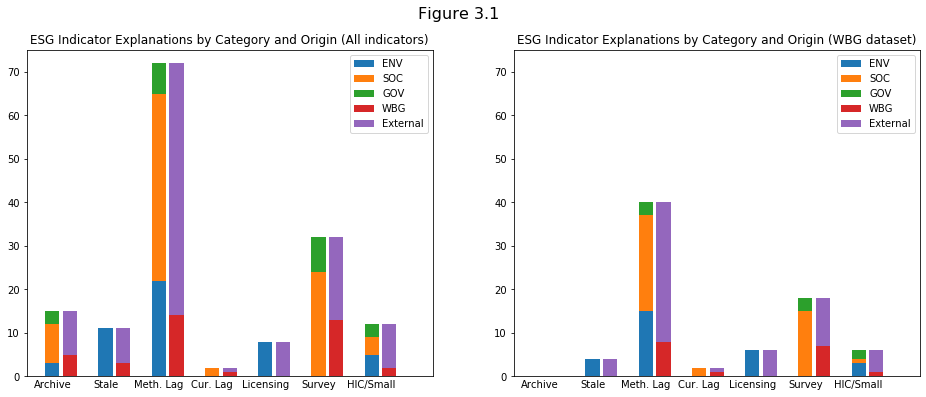

In [21]:
# plots
def every_other(n,odd=True,fill=0):
    z = list(chain.from_iterable(list(map(lambda x: [fill,x,fill], n))))
    if odd:
        z = z[1:]
        z.append(fill)
    
    return z

def plot_esg(limit):
    esg2 = esg[(esg['wbgv1']==1) | (not limit)]
    sector_data = esg2.groupby(['sector']).sum()[expl_a_g]
    origin_data = esg2.groupby(['domain']).sum()[expl_a_g]
    sx = range(0,len(sector_data.columns)*3)

    pEnv = plt.bar(sx, every_other(sector_data.loc['ENV']))
    pSoc = plt.bar(sx, every_other(sector_data.loc['SOC']),bottom=every_other(sector_data.loc['ENV']))
    pGov = plt.bar(sx, every_other(sector_data.loc['GOV']),bottom=every_other(sector_data.loc['ENV']+sector_data.loc['SOC']))
    pWbg = plt.bar(sx, every_other(origin_data.loc['WBG'],False))
    pExt = plt.bar(sx, every_other(origin_data.loc['EXTERNAL'],False),bottom=every_other(origin_data.loc['WBG'],False))
    plt.xticks(sx, labels=every_other(['Archive', 'Stale', 'Meth. Lag', 'Cur. Lag', 'Licensing', 'Survey', 'HIC/Small'],fill=None))
    plt.tick_params(axis='x', length=0)
    plt.ylim(0, 75)

    plt.legend((pEnv, pSoc, pGov,pWbg, pExt), ('ENV', 'SOC', 'GOV', 'WBG', 'External'))
    plt.title('ESG Indicator Explanations by Category and Origin ({})'.format('WBG dataset' if limit else 'All indicators'))

plt.figure(figsize=(16,6)).suptitle('Figure 3.1', fontsize=16)
plt.subplot(1, 2, 1)
plot_esg(False)
plt.subplot(1, 2, 2)
plot_esg(True)

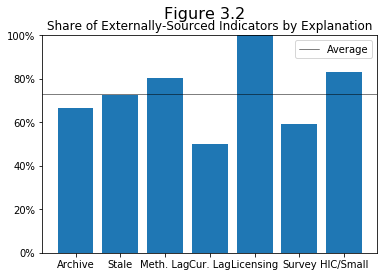

In [20]:
import matplotlib.ticker as ticker

def plot_shares(ax, columns, data, ref):
    
    ax.bar(range(0,len(columns)), data)
    plt.xticks(range(0,len(columns)), ['Archive', 'Stale', 'Meth. Lag', 'Cur. Lag', 'Licensing', 'Survey', 'HIC/Small'])
    plt.ylim(0,1)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
    if ref:
        ax.axhline(ref, 0, len(columns), lw=0.5, color='black',label='Average')
        ax.legend()

esg2 = esg.groupby('domain').sum()[expl_a_g]

for i in esg2.columns:
    esg2[i] = esg2[i] / esg2[i].sum()

plt.figure().suptitle('Figure 3.2', fontsize=16)
plot_shares(plt.subplot(), esg2.columns, esg2.loc['EXTERNAL'], work.loc['EXTERNAL', 'Total'])
plt.title('Share of Externally-Sourced Indicators by Explanation')
plt.show()

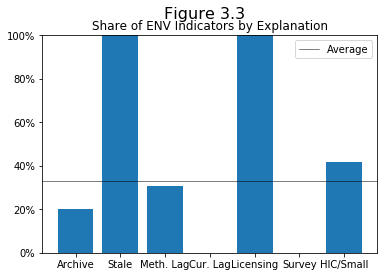

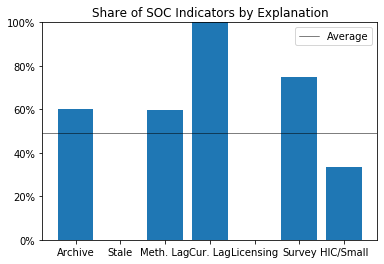

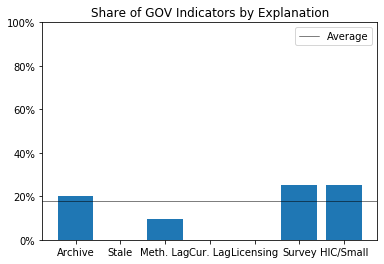

In [19]:

esg2 = esg.groupby('sector').sum().reindex(['ENV', 'SOC', 'GOV'])[expl_a_g]

for i in esg2.columns:
    esg2[i] = esg2[i] / esg2[i].sum()

plt.figure().suptitle('Figure 3.3', fontsize=16)
n = 1
for c in esg2.index:
    
    plot_shares(plt.subplot(), esg2.columns, esg2.loc[c], work.loc['Total', c])
    plt.title('Share of {} Indicators by Explanation'.format(c))
    plt.show()
    n = n+1

# hmm, this could definitely be better. Perhaps combine into one chart similar to Fig. 3.1?